<h1 align=center><font size = 6>Capston Project - The Battle of the Neighborhoods</font></h1>

<h1 align=center><font size = 5>Applied Data Science Capston by IBM/Coursera</font></h1>

<h1 align=center><font size = 4>Zhayida Simayijiang</font></h1>

<h1 align=center><font size = 3>2020-02-27</font></h1>

## Introduction

The entire Stockholm metropolitan area consisting of 26 municipalities and has a population of over 2.2 million making it the most populous city in the Nordic region. It has a population density of 5.200 people per square kilometer [1].

Stockholm is a city with high population and population density in Sweden, and living cost is comparably higher than other cities of Sweden as well. Newcomers of the city may want to choose the area where housing price is lower but still not too far away from social places.

The goal is to build a recommendation system for a residence decide on which municipality to live among the 26 municipalities in Stockholm. In this project, I aim to describe different municipalities of Stockholm by studying surrounding available venues. I create a map and information chart where the real estate index is placed on Stockholm and each municipality is clustered according to the venue density. The result may useful for people who is moving to Stockholm and wanted to find a place which is match to one’s economy as well as lifestyle and hobbies.

## Data Description

What and where to collect the data are essential step in this project. I used GitHub repository in my study.

1. I download the excel file from Svensk Mäklarstatistik [2]. The file has average house price of all cities of Sweden. I cleaned the data and reduced it to city of Stockholm. 
2. I used Google [4] to get the equivalent latitude and longitude values of each municipality in Stockholm.
3. I used ___Forsquare API___ [3] to explore neighborhood venues in Stockholm.
4. List of Foursquare's main and lower level categories originally downloaded from 
https://developer.foursquare.com/docs/resources/categories.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

0. <a href="#Import Libraries">Import Libraries</a>

1. <a href="#Download and Explore Dataset">Download and Explore Dataset</a>

2. <a href="#Explore Neighborhoods in Stockholm">Explore Neighborhoods in Stockholm</a>

3. <a href="#Analyze Each Neighborhood">Analyze Each Neighborhood</a>

4. <a href="#Cluster Neighborhoods">Cluster Neighborhoods</a>

5. <a href="#Examin Clusters">Examin Clusters</a>

6. <a href="#Results and Discussion">Results and Discussion</a>

7. <a href="#Summary">Summary</a>

8. <a href="#References">References</a>
</font>
</div>

## 0. Import Libraries <a name="Import Libraries"></a>

###### Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
import numpy as np # library to handle data in a vectorized manner
from pandas import *
import math

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install selenium
import selenium.webdriver
import six

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset <a name="Download and Explore Dataset"></a>

###### Downlad data
I get the list of municipalities of Stockholm, and their geographical coordinates and also average housing price in each municipality.

In [5]:
data = pd.read_excel(r'C:\Users\Zayide\Dropbox\CapstonFinalProject\STHML_HousePrice.xlsx')
df = pd.DataFrame(data, columns= ['Municipality','Average price','Price Label','Latitude','Longitude'])
df.head()

,Municipality,Average price,Price Label,Latitude,Longitude
0,Upplands Väsby,4638,4,59.5196,17.9283
1,Vallentuna,4459,4,59.5357,18.0780
2,Österåker,4421,4,59.4818,18.2979
3,Värmdö,4730,4,59.3164,18.4466
4,Järfälla,4883,4,59.4101,17.8368


Note:

* ___Average price___ refers to average housing price.

* ___Price Label 1:___ when price in range [1000, 2000], ___Price Label 2:___ when price in range [2000, 3000] and so on, ___Price Label 11:___ when price in range [11000, 12000].

As shown above, my master data has components Kommun, Average price in 1000SEK, Latitude and Longitude information of the city.

###### Data visulization
I used python ___folium___ library to create the map of Stockholm and marked the municipalites on top. I used latitude and longitude values to get the map as below:

Get the geographical coordinates of Stockholm

In [7]:
# Use geopy library to get the latitude and longitude values of Stockholm
address = 'Stockholm, STHLM'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [9]:
# create map of Stockholm
map_sthlm = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Municipality']):
#for lat, lng, label in zip(sthlm_metro_4.lat, sthlm_metro_4.lng, sthlm_metro_4.stations):
#    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='beige',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sthlm)  

    
map_sthlm.save("sthlm_municipality.html")
driver = selenium.webdriver.PhantomJS(r'C:\Users\Zayide\Dropbox\CapstonFinalProject\phantomjs-2.1.1-windows\bin\phantomjs')
driver.set_window_size(900, 700)  # choose a resolution
driver.get('sthlm_municipality.html')
# You may need to add time.sleep(seconds) here
driver.save_screenshot('sthlm_municipality.png')

map_sthlm



## 2. Explore Neighborhoods in Stockholm <a name="Explore Neighborhoods in Stockholm"></a>

#### Define Foursquare Credentials and Version

In [1]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


###### Get the top 100 venues that are within a radius of 650 meters.

In [9]:
# Create the GET request URL. Name your URL url.
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 650 # radius around every metro station

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

# Send the GET request and examine the results
results = requests.get(url).json()
# result

# function that extracts the category of the venue
# All the information in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

###### Clean the json and structure it into a pandas dataframe

In [10]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Science Fiction Bokhandeln,Bookstore,59.324047,18.070682
1,Tweed,Cocktail Bar,59.324471,18.067696
2,The Burgundy,Wine Bar,59.324434,18.068161
3,Stortorget,Plaza,59.324973,18.070727
4,Barrels Burgers & Beer,Burger Joint,59.324685,18.068513


###### Define function for get nearby venues in given radius and limit

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Municipality Latitude', 
                  'Municipality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *sthlm_venues*.

In [12]:
sthlm_venues = getNearbyVenues(names = df['Municipality'],
                                   latitudes = df['Latitude'],
                                   longitudes = df['Longitude'])

Upplands Väsby
Vallentuna
Österåker
Värmdö
Järfälla
Ekerö
Huddinge
Botkyrka
Salem
Haninge
Tyresö
Upplands-Bro
Nykvarn
Täby
Danderyd
Sollentuna
Stockholm
Södertälje
Nacka
Sundbyberg
Solna
Lidingö
Vaxholm
Norrtälje
Sigtuna
Nynäshamn


#### Lets check the size of the resulting dataframe

In [13]:
print(sthlm_venues.shape)
sthlm_venues.head()

(917, 7)


,Municipality,Municipality Latitude,Municipality Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,Upplands Väsby,59.5196,17.9283,Sibylla Mammas,59.513921,17.929729,Fast Food Restaurant
1,Upplands Väsby,59.5196,17.9283,Midoh Kitchen,59.521050,17.904087,Sushi Restaurant
2,Upplands Väsby,59.5196,17.9283,Väsby Nya Konditori,59.520905,17.905400,Café
3,Upplands Väsby,59.5196,17.9283,Waynes Coffee,59.518562,17.911404,Coffee Shop
4,Upplands Väsby,59.5196,17.9283,Circle K,59.513968,17.919595,Convenience Store


<font color='green'>___Overall Foursquare returned 917 venues with given radius and limit. Above is a merged table of municipality and its venues.I utilized the Foursquare API to explore the municipality and get top 100 venues that are within a radius of 2km to each municipality. Above is the list created from Forsquare API, its contains information about venue's name, category, latitude and longitude.___

#### Let's check how many venues returned for each municipality

In [122]:
# How many venues were returned for each neighborhood
df1 = sthlm_venues.groupby('Municipality').count()
df1['Venue']

Municipality
Botkyrka           25
Danderyd           34
Ekerö               6
Haninge            43
Huddinge           25
Järfälla           55
Lidingö            35
Nacka              69
Norrtälje          17
Nykvarn             4
Nynäshamn          24
Salem               6
Sigtuna            21
Sollentuna         54
Solna              96
Stockholm         100
Sundbyberg        100
Södertälje         30
Tyresö              8
Täby               56
Upplands Väsby     25
Upplands-Bro        4
Vallentuna         11
Vaxholm            22
Värmdö             18
Österåker          29
Name: Venue, dtype: int64

<font color='green'>___We can see that Stockholm municipality has reached 100 limit of venues. On the other hand, Danderyd, Ekerö, Huddinge, Järfälla, Norrtälje, Nykvarn, Salem, Sigtuna, Tyresö, Upplands Väsby, Upplands-Bro, Vallentuna, Vaxholm, Värmdö municipality are fetch below 20 venues. We get different number of venues for each municipality depending on given latitude and longitude information.___

#### How many unique categories can be curated from all the returned venues?

In [123]:
print('There are {} uniques categories.'.format(len(sthlm_venues['Category'].unique())))

There are 165 uniques categories.


#### What are the unique categories that curated from all the returned venues?

In [124]:
sthlm_venues['Category'].unique()

array(['Fast Food Restaurant', 'Sushi Restaurant', 'Café', 'Coffee Shop',
       'Convenience Store', 'Thai Restaurant', 'Shopping Mall',
       'Gym / Fitness Center', 'Grocery Store', 'Gastropub',
       'Supermarket', 'Skating Rink', 'Clothing Store', 'Shoe Store',
       'Bakery', 'Pizza Place', 'Bus Stop', 'Platform', 'Bus Station',
       'Gym', 'Plaza', 'Liquor Store', 'Light Rail Station',
       'Soccer Field', 'Restaurant', 'Flower Shop', 'Bar', 'Pharmacy',
       'Burger Joint', 'Athletics & Sports', 'Stadium', 'Nature Preserve',
       'Canal Lock', 'Automotive Shop', 'Discount Store', 'Hotel',
       'Forest', 'Golf Course', 'Beach', 'Gas Station',
       'Scandinavian Restaurant', 'Furniture / Home Store',
       'Department Store', 'Trail', 'Indoor Play Area',
       'Sporting Goods Shop', 'Electronics Store', 'Outlet Store',
       'Bistro', 'Garden Center', 'Greek Restaurant', 'Bowling Alley',
       'Train Station', 'Dessert Shop', 'Pet Store', 'Diner', 'Farm',
      

#### What is the total number of venues returned for each municipality?

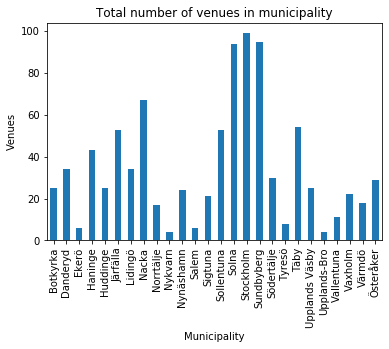

In [125]:
sthlm_venues.groupby('Municipality')['Venue'].nunique().plot(kind='bar')
#sthlm_venues.plot(kind = 'bar', x = 'Kommun', y = 'Venue')
plt.title('Total number of venues in municipality')
plt.ylabel('Venues')
plt.show()

<font color='green'>___From above figure, we can see that total number of venues returned for Stockholm municipality is the highest.___ </font>

#### From returned  venues for each municipalities, how many unique categories each municipalities has?

In [175]:
sthlm_venues.groupby('Municipality')['Category'].nunique()

Municipality
Botkyrka          23
Danderyd          25
Ekerö              6
Haninge           30
Huddinge          22
Järfälla          34
Lidingö           24
Nacka             44
Norrtälje         12
Nykvarn            4
Nynäshamn         17
Salem              6
Sigtuna           11
Sollentuna        37
Solna             61
Stockholm         52
Sundbyberg        51
Södertälje        24
Tyresö             6
Täby              35
Upplands Väsby    19
Upplands-Bro       4
Vallentuna         9
Vaxholm           17
Värmdö            16
Österåker         22
Name: Category, dtype: int64

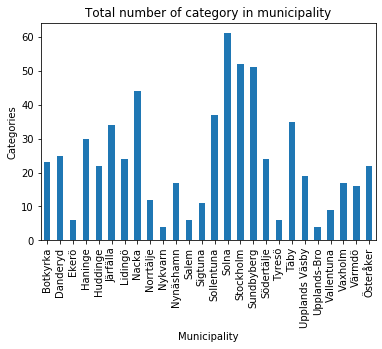

In [126]:
sthlm_venues.groupby('Municipality')['Category'].nunique().plot(kind='bar')
plt.title('Total number of category in municipality')
plt.ylabel('Categories')
plt.show()

<font color='green'>___From above figure, we can see that Solna municipality has highest category value, that means it has variety of venues nearby.___ </font>

#### What is the 10 most frequent occuring venue category?

In [127]:
# create a dataframe of top 10 categories
sthlm_venues_Top10 = sthlm_venues['Category'].value_counts()[0:10].to_frame(name='frequency')
sthlm_venues_Top10 = sthlm_venues_Top10.reset_index()


sthlm_venues_Top10.rename(index=str, columns={"index": "Category", "frequency": "Frequency"}, inplace=True)
sthlm_venues_Top10

,Category,Frequency
0,Grocery Store,50
1,Café,41
2,Pizza Place,37
3,Scandinavian Restaurant,37
4,Hotel,33
5,Gym / Fitness Center,32
6,Supermarket,32
7,Shopping Mall,23
8,Fast Food Restaurant,22
9,Park,22


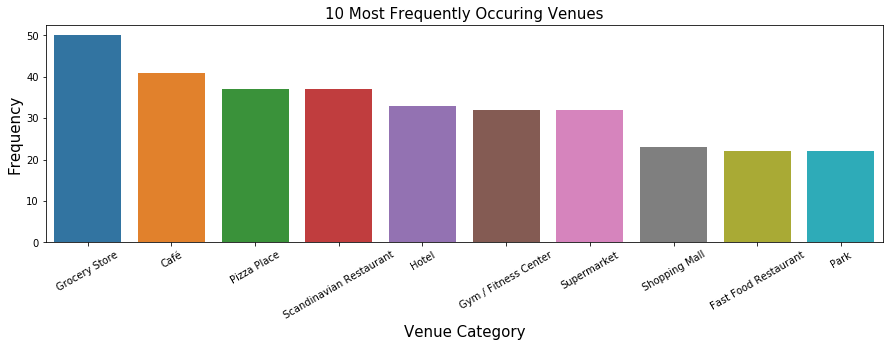

In [185]:

fig = plt.figure(figsize=(15,4))
s = sns.barplot(x = "Category", y="Frequency", data = sthlm_venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=500)
plt.show()

<font color='green'>From above analysis, we can see that ___Gtocery Store___ is one of the most frequent venues in Stockholm.

## 3. Analyze Each Neighborhood <a name="Analyze Each Neighborhood"></a>

#### Let's create a new dataframe where all the municipalities with 10 or less venues are removed. Then the dataframe will be used for clustering.

In [129]:
calm_municipality = df1
calm_municipality.drop(calm_municipality[calm_municipality['Venue']> 12].index, inplace = True)
calm_municipality = calm_municipality.drop('Venue',1)
calm_municipality

,Municipality Latitude,Municipality Longitude,Venue Latitude,Venue Longitude,Category
Municipality,,,,,
Ekerö,6,6,6,6,6
Nykvarn,4,4,4,4,4
Salem,6,6,6,6,6
Tyresö,8,8,8,8,8
Upplands-Bro,4,4,4,4,4
Vallentuna,11,11,11,11,11


In [130]:
sthlm_venues_2 = sthlm_venues.groupby('Municipality').filter(lambda x : len(x) > 11 )
sthlm_venues_2.shape

(878, 7)

From the above result we can see that, in toal 28 events are removed from the dataframe. (917-889 = 28)

#### One hot encoding

In [131]:
# one hot encoding
sthlm_onehot = pd.get_dummies(sthlm_venues_2[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sthlm_onehot['Municipality'] = sthlm_venues_2['Municipality'] 

# move neighborhood column to the first column
fixed_columns = [sthlm_onehot.columns[-1]] + list(sthlm_onehot.columns[:-1])
sthlm_onehot = sthlm_onehot[fixed_columns]

sthlm_onehot.head()

,Municipality,Airport Service,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Candy Store,Castle,Chinese Restaurant,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Library,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Opera House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Palace,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Tram Station,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Upplands Väsby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Upplands Väsby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Upplands Väsby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Upplands Väsby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Upplands Väsby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [132]:
sthlm_onehot.shape

(878, 165)

#### Next, let's group rows by municipality and by taking the mean of the frequency of occurrence of each category

In [133]:
sthlm_grouped = sthlm_onehot.groupby('Municipality').mean().reset_index()
sthlm_grouped

,Municipality,Airport Service,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Canal Lock,Candy Store,Castle,Chinese Restaurant,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Construction & Landscaping,Convenience Store,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Library,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Opera House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Palace,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Tram Station,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Botkyrka,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.040000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.04,0.000000,0.040000,0.000000,0.000000,0.00,0.040000,0.00,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00,0.080000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.08,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.04,0.000000,0.000000,0.000000,0.000000,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.04,0.000000,0.040000,0.000000,0.000000,0.00,0.00,0.00
1,Danderyd,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.029412,0.058824,0.088235,0.000000,0.000000,0.058824,0.000000,0.00,0.029412,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.029412,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0

Let's confirm the new size

In [134]:
sthlm_grouped.shape

(20, 165)

#### Let's print each neighborhood along with the top 5 most common venues

In [135]:
num_top_venues = 5

for hood in sthlm_grouped['Municipality']:
    print("----"+hood+"----")
    temp = sthlm_grouped[sthlm_grouped['Municipality'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Botkyrka----
                  venue  freq
0         Metro Station  0.08
1  Fast Food Restaurant  0.08
2          Soccer Field  0.04
3         Shopping Mall  0.04
4      Community Center  0.04


----Danderyd----
                venue  freq
0         Bus Station  0.09
1               Hotel  0.06
2         Pizza Place  0.06
3         Golf Course  0.06
4  Light Rail Station  0.06


----Haninge----
                  venue  freq
0           Supermarket  0.07
1           Bus Station  0.07
2     Electronics Store  0.07
3  Gym / Fitness Center  0.05
4     Convenience Store  0.05


----Huddinge----
                  venue  freq
0  Gym / Fitness Center  0.08
1                  Park  0.08
2                Bakery  0.08
3       Thai Restaurant  0.04
4      Dentist's Office  0.04


----Järfälla----
                  venue  freq
0   Sporting Goods Shop  0.09
1         Grocery Store  0.07
2  Fast Food Restaurant  0.05
3           Supermarket  0.05
4         Train Station  0.04


----Lidingö----
  

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [136]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [137]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Municipality'] = sthlm_grouped['Municipality']

for ind in np.arange(sthlm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sthlm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Botkyrka,Metro Station,Fast Food Restaurant,Department Store,Supermarket,Food,Café,Shopping Mall,Soccer Field,Electronics Store,Pizza Place
1,Danderyd,Bus Station,Hotel,Café,Burger Joint,Park,Golf Course,Light Rail Station,Pizza Place,Supermarket,Breakfast Spot
2,Haninge,Electronics Store,Bus Station,Supermarket,Coffee Shop,Bowling Alley,Convenience Store,Department Store,Shopping Mall,Gym / Fitness Center,Furniture / Home Store
3,Huddinge,Bakery,Gym / Fitness Center,Park,Fast Food Restaurant,Moving Target,Pizza Place,Furniture / Home Store,Farm,Stadium,Liquor Store
4,Järfälla,Sporting Goods Shop,Grocery Store,Supermarket,Fast Food Restaurant,Hotel,Furniture / Home Store,Electronics Store,Department Store,Pizza Place,Plaza


## 4. Cluster Neighborhoods <a name="Cluster Neighborhoods"></a>

### 4.1 Find the optimal number of clusters

In order to determine the optimal number of clusters, two diffents methods are used. The elbow method and silhouette score.

##### Elbow method

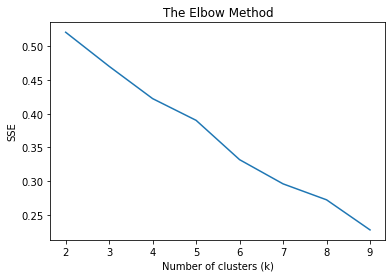

In [138]:
sthlm_grouped_clustering = sthlm_grouped.drop('Municipality', 1)
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(sthlm_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.title('The Elbow Method')
plt.show()

<font color='green'>___The Elbow method did not give very clear bend.___ 

#### Silhouette method

In [139]:
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=1)
    preds = clusterer.fit_predict(sthlm_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score (sthlm_grouped_clustering, preds, metric='euclidean')
    print(n_clusters, round(score,4))

2 0.2075
3 0.1441
4 0.1298
5 0.0292
6 0.1055
7 0.0859
8 0.0427
9 0.0309


<font color='green'>___The silhouette method indicates that the optimal number of clusters for the dataset is k = 3 since it has the hightest score.___

### 4.2 *k*-means clustering

Run *k*-means to cluster the neighborhood into 4 clusters.

In [141]:
# set number of clusters
kclusters = 2

sthlm_grouped_clustering = sthlm_grouped.drop('Municipality', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sthlm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:26])
print(Counter(kmeans.labels_))

[1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1]
Counter({1: 15, 0: 5})


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [142]:
# add clustering labels
#sthlm_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [150]:
sthlm_merged = df

# merge sthlm_grouped with sthlm_data to add latitude/longitude for each neighborhood
sthlm_merged = sthlm_merged.join(neighborhoods_venues_sorted.set_index('Municipality'), on='Municipality')

sthlm_merged # check the last columns!

,Municipality,Average price,Price Label,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Upplands Väsby,4638,4,59.5196,17.9283,1.0,Pizza Place,Gym / Fitness Center,Grocery Store,Shopping Mall,Fast Food Restaurant,Clothing Store,Bakery,Bus Stop,Shoe Store,Café
1,Vallentuna,4459,4,59.5357,18.0780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Österåker,4421,4,59.4818,18.2979,1.0,Pizza Place,Supermarket,Sushi Restaurant,Grocery Store,Light Rail Station,Hotel,Discount Store,Canal Lock,Restaurant,Flower Shop
3,Värmdö,4730,4,59.3164,18.4466,1.0,Department Store,Grocery Store,Gas Station,Bakery,Bus Stop,Shopping Mall,Café,Flower Shop,Liquor Store,Furniture / Home Store
4,Järfälla,4883,4,59.4101,17.8368,1.0,Sporting Goods Shop,Grocery Store,Supermarket,Fast Food Restaurant,Hotel,Furniture / Home Store,Electronics Store,Department Store,Pizza Place,Plaza
5,Ekerö,5167,5,59.2798,17.7902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Huddinge,5215,5,59.2363,17.9822,1.0,Bakery,Gym / Fitness Center,Park,Fast Food Restaurant,Moving Target,Pizza Place,Furniture / Home Store,Farm,Stadium,Liquor Store
7,Botkyrka,4310,4,59.2459,17.8409,1.0,Metro Station,Fast Food Restaurant,Department Store,Supermarket,Food,Café,Shopping Mall,Soccer Field,Electronics Store,Pizza Place
8,Salem,4553,4,59.2077,17.7742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Haninge,4208,4,59.1756,18.1414,1.0,Electronics Store,Bus Station,Supermarket,Coffee Shop,Bowling Alley,Convenience Store,Department Store,Shopping Mall,Gym / Fitness Center,Furniture / Home Store


Finally, let's visualize the resulting clusters

In [161]:
sthlm_merged.iloc[[1,5,8,10,11,12],sthlm_merged.columns.get_loc('Cluster Labels')] = 2
sthlm_merged["Cluster Labels"] = sthlm_merged["Cluster Labels"].astype(int)
sthlm_merged

,Municipality,Average price,Price Label,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Upplands Väsby,4638,4,59.5196,17.9283,1,Pizza Place,Gym / Fitness Center,Grocery Store,Shopping Mall,Fast Food Restaurant,Clothing Store,Bakery,Bus Stop,Shoe Store,Café
1,Vallentuna,4459,4,59.5357,18.0780,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Österåker,4421,4,59.4818,18.2979,1,Pizza Place,Supermarket,Sushi Restaurant,Grocery Store,Light Rail Station,Hotel,Discount Store,Canal Lock,Restaurant,Flower Shop
3,Värmdö,4730,4,59.3164,18.4466,1,Department Store,Grocery Store,Gas Station,Bakery,Bus Stop,Shopping Mall,Café,Flower Shop,Liquor Store,Furniture / Home Store
4,Järfälla,4883,4,59.4101,17.8368,1,Sporting Goods Shop,Grocery Store,Supermarket,Fast Food Restaurant,Hotel,Furniture / Home Store,Electronics Store,Department Store,Pizza Place,Plaza
5,Ekerö,5167,5,59.2798,17.7902,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Huddinge,5215,5,59.2363,17.9822,1,Bakery,Gym / Fitness Center,Park,Fast Food Restaurant,Moving Target,Pizza Place,Furniture / Home Store,Farm,Stadium,Liquor Store
7,Botkyrka,4310,4,59.2459,17.8409,1,Metro Station,Fast Food Restaurant,Department Store,Supermarket,Food,Café,Shopping Mall,Soccer Field,Electronics Store,Pizza Place
8,Salem,4553,4,59.2077,17.7742,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Haninge,4208,4,59.1756,18.1414,1,Electronics Store,Bus Station,Supermarket,Coffee Shop,Bowling Alley,Convenience Store,Department Store,Shopping Mall,Gym / Fitness Center,Furniture / Home Store


In [163]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8.4)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
#markers_colors = []
#for lat, lon, poi, cluster in zip(sthlm_merged['Latitude'], sthlm_merged['Longitude'], sthlm_merged['Municipality'], sthlm_merged['Cluster Labels']):
#    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#    folium.CircleMarker(
#        [lat, lon],
#        radius=5,
#        popup=label,
#        color=rainbow[cluster-1],
#        fill=True,
#        fill_color=rainbow[cluster-1],
#        fill_opacity=0.7).add_to(map_clusters)

    
# set the color scheme for the clusters and add markers to the map
colors = ['red','green','purple']
fillers = ['red','green','purple']

for lat, lon, poi, cluster in zip(sthlm_merged['Latitude'], sthlm_merged['Longitude'], sthlm_merged['Municipality'], sthlm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=fillers[cluster],
        fill_opacity=0.7).add_to(map_clusters)    
    
    
map_clusters.save("map_clusters.html")
driver = selenium.webdriver.PhantomJS(r'C:\Users\Zayide\Dropbox\CapstonFinalProject\phantomjs-2.1.1-windows\bin\phantomjs')
driver.set_window_size(900, 700)  # choose a resolution
driver.get('map_clusters.html')
# You may need to add time.sleep(seconds) here
driver.save_screenshot('map_clusters.png')
                       
map_clusters

<font color='green'>___This looks awsome!___

## 5. Examin Clusters <a name="Examin Clusters"></a>

Now I can examine each cluster and determine the descriminating venue categories that distinguish eahc cluster. Based on the defining categories, I can then assign a name to each cluster.

#### Cluster 0

In [164]:
sthlm_cluster0 = sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 0, sthlm_merged.columns[[1] + list(range(5, sthlm_merged.shape[1]))]]

print ("Nr. of Municipalities in Cluster Label 0: %d" %(sthlm_cluster0.shape[0]))
sthlm_cluster0

Nr. of Municipalities in Cluster Label 0: 5


,Average price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,7181,0,Scandinavian Restaurant,Hotel,Seafood Restaurant,Cocktail Bar,Park,Bakery,Burger Joint,Café,Coffee Shop,Clothing Store
22,6566,0,Restaurant,Harbor / Marina,Café,Bus Stop,Hotel,Supermarket,Ice Cream Shop,Grocery Store,Park,Pier
23,2806,0,Burger Joint,Food,Department Store,Café,Supermarket,Restaurant,Scandinavian Restaurant,Liquor Store,Hotel,Grocery Store
24,4416,0,Hotel,Café,Scandinavian Restaurant,Restaurant,Historic Site,Pizza Place,Burger Joint,Harbor / Marina,History Museum,Grocery Store
25,3507,0,Hotel,Boat or Ferry,Grocery Store,Café,Scandinavian Restaurant,Beach,Liquor Store,Deli / Bodega,Pier,Pizza Place


#### Cluster 1

In [165]:
sthlm_cluster1 = sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 1, sthlm_merged.columns[[1] + list(range(5, sthlm_merged.shape[1]))]]

print ("Nr. of Municipalities in Cluster Label 1: %d" %(sthlm_cluster1.shape[0]))
sthlm_cluster1

Nr. of Municipalities in Cluster Label 1: 15


,Average price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4638,1,Pizza Place,Gym / Fitness Center,Grocery Store,Shopping Mall,Fast Food Restaurant,Clothing Store,Bakery,Bus Stop,Shoe Store,Café
2,4421,1,Pizza Place,Supermarket,Sushi Restaurant,Grocery Store,Light Rail Station,Hotel,Discount Store,Canal Lock,Restaurant,Flower Shop
3,4730,1,Department Store,Grocery Store,Gas Station,Bakery,Bus Stop,Shopping Mall,Café,Flower Shop,Liquor Store,Furniture / Home Store
4,4883,1,Sporting Goods Shop,Grocery Store,Supermarket,Fast Food Restaurant,Hotel,Furniture / Home Store,Electronics Store,Department Store,Pizza Place,Plaza
6,5215,1,Bakery,Gym / Fitness Center,Park,Fast Food Restaurant,Moving Target,Pizza Place,Furniture / Home Store,Farm,Stadium,Liquor Store
7,4310,1,Metro Station,Fast Food Restaurant,Department Store,Supermarket,Food,Café,Shopping Mall,Soccer Field,Electronics Store,Pizza Place
9,4208,1,Electronics Store,Bus Station,Supermarket,Coffee Shop,Bowling Alley,Convenience Store,Department Store,Shopping Mall,Gym / Fitness Center,Furniture / Home Store
13,6910,1,Grocery Store,Pizza Place,Gym / Fitness Center,Electronics Store,Coffee Shop,Flower Shop,Bakery,Clothing Store,Fast Food Restaurant,Juice Bar
14,10965,1,Bus Station,Hotel,Café,Burger Joint,Park,Golf Course,Light Rail Station,Pizza Place,Supermarket,Breakfast Spot
15,6787,1,Grocery Store,Pizza Place,Bus Station,Scandinavian Restaurant,Gym / Fitness Center,Convenience Store,Diner,Coffee Shop,Park,Bus Stop


#### Cluster 2

In [166]:
sthlm_cluster2 = sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 2, sthlm_merged.columns[[1] + list(range(5, sthlm_merged.shape[1]))]]

print ("Nr. of Municipalities in Cluster Label 2: %d" %(sthlm_cluster2.shape[0]))
sthlm_cluster2

Nr. of Municipalities in Cluster Label 2: 6


,Average price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,4459,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5167,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4553,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,5377,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,4076,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,3429,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### What is the unique venues in *1st Most Common Venue*?

In [167]:
sthlm_merged['1st Most Common Venue'].unique()

array(['Pizza Place', nan, 'Department Store', 'Sporting Goods Shop',
       'Bakery', 'Metro Station', 'Electronics Store', 'Grocery Store',
       'Bus Station', 'Scandinavian Restaurant', 'Supermarket', 'Café',
       'Restaurant', 'Burger Joint', 'Hotel'], dtype=object)

#### Visulize classification result by *1st  Most Common Venues*

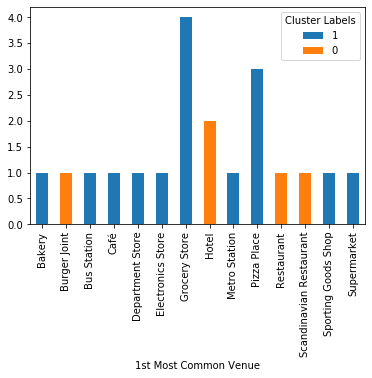

In [168]:
#sthlm_merged.plot(kind = 'bar', x = '1st Most Common Venue', y = 'Cluster Labels')
#plt.title('1st Most Common Venues')
#plt.ylabel('Cluster Labels')
#plt.show()

#sthlm_merged.plot(kind = 'bar', x = '2nd Most Common Venue', y = 'Cluster Labels')
#plt.title('2nd Most Common Venues')
#plt.ylabel('Cluster Labels')
#plt.show()

sthlm_merged.groupby(['1st Most Common Venue','Cluster Labels']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

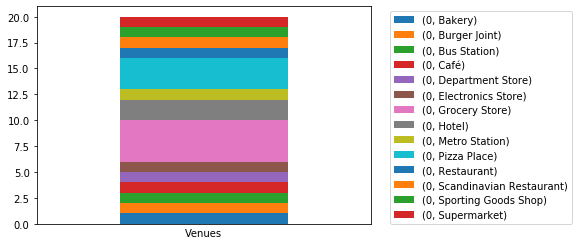

In [169]:
# create dummy variable them group by that
# set the legend to false because we'll fix it later
sthlm_merged.assign(dummy = 1).groupby(
  ['dummy','1st Most Common Venue']
).size().to_frame().unstack().plot(kind='bar',stacked=True,legend=False)

# other it'll show up as 'dummy' 
plt.xlabel('Venues')

# disable ticks in the x axis
plt.xticks([])

# fix the legend
current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)

labels = reversed(sthlm_merged['1st Most Common Venue'].unique())

#plt.legend(reversed_handles,labels,loc='lower right')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

#### Count the 1st Most Common Venue of all municipalities and split by cluster label.

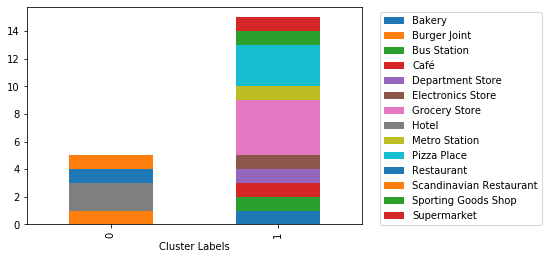

In [181]:
sthlm_merged.groupby(['Cluster Labels','1st Most Common Venue']).size().unstack().plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

#### Stacked bar plot with three-level group by, normalized to 100%

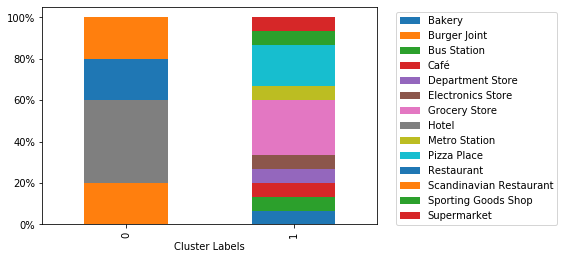

In [183]:
sthlm_merged.groupby(['Cluster Labels','1st Most Common Venue']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

<font color='green'>If we group the ___1st Most Commun Venue___ of each venues, we get above figure. Furthure, we can label each clusters as follows:

* Cluster 0: "Hotel & Resturant"

* Cluster 1: "Multiple social venues"

* Cluster 2: "Calm area"

## 6. Results and Discussion <a name="Results and Discussion"></a>

#### Average house price in each municipality

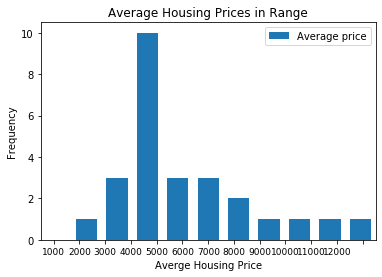

In [184]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) + 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

bins = [1000,2000,3000,4000,5000, 6000,7000,8000,9000,10000,11000,12000]
sthlm_merged[['Average price']].plot(kind = 'hist', bins = bins, rwidth = 0.7)
bins_labels(bins, fontsize=9)
plt.title('Average Housing Prices in Range')
plt.xlabel('Averge Housing Price')
plt.show()

<font color='green'>___The most common average price range is between 4000 to 5000 SEK.___

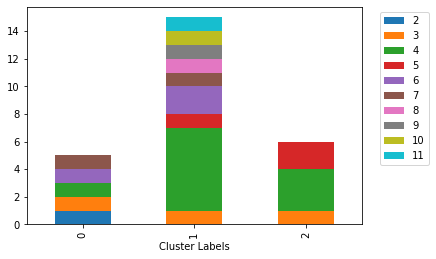

In [177]:
sthlm_merged.groupby(['Cluster Labels','Price Label']).size().unstack().plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

I assgined the price label for each price range, for example [2000,3000] has price label 2, [3000,4000] has price label 3 and so on.

From above figure, we can see that Cluster 1 has most expensive housing price includes price ranges from 8000 SEK to 12000 SEK (see legend 8,9,11), but not other two clusters. And, according to neighborhood clustering result, we named Cluster 1 as “Multiple Social Venues”. It aligns with our assumption that the municipalities which surrounding by different social venues are naturally have a higher housing price.

On the other hand, Cluster 2 has price range from 3000 SEK to 5000 SEK. Those are the areas that surrounding venues are less than 11 in 2kilometer distance. We named this area as calm areas. 

Cluster 0 includes average price range between 2000 SEK to 8000 SEK and have plenty of variety venues. 

Different clusters can be categorized as following:
* Cluster 0 (k = 0, red) includes 5 municipalities. Cluster label name: “Hotel & Restaurant”
* Cluster 1 (k = 1, green) includes 15 municipalities. Cluster label name: “Multiple Social Venues”
* Cluster 2 (k = 2, blue) includes 6 municipalities. Cluster label name: “Calm area”

## 7. Summary <a name="Summary"></a>

___What was my purpose?___

The aim of the project is to cluster different municipalities of Stockholm so that newcommers can choose the municipality where they can live but also not too far away from social places.

___What I did or learned?___

In this project, I have studied how to convert addresses into their equivalend latitude and longitude values. Also, I have used Foursquare API to explore neighborhoods in Stockholm City. I used the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. In the end, I have used *k*-means clustering algorithm to complete this task. Finally, I have used the Folium library to visulize the neighborhoods in Stockholm Cith and their emerging clusters.
 
 
___What is next?___

The aim of this project is to cluster different municipalities in Stockholm based on surronding venues. For that, Foursquare venue data is used. The venues returned by Foursquare is mainly food, stores and lifestyle related categories, so the housing price infomation added for the furthur analysis. I believe it would be intresting if one can add information like metro station, daycare/school, university or hospital information. This could potentially valuable for who have kids or elder/sick people who needs to visit a hospital often. 

One can do more advanced or accurate analysis with more information input as explained in Discussion section. I would love to revisit this project in the future and do more advanced analysis! Until then!

## 8. References <a name="References"></a>

[1] [Stockholm --- Wikipedia](https://en.wikipedia.org/wiki/Stockholm)

[2] [Svensk Mäklarstatistik](https://www.maklarstatistik.se/)

[3] [Forsquare API](https://developer.foursquare.com/)

[4] [Google](https://www.google.com)
